<a href="https://colab.research.google.com/github/mreskandarinasab/Brain-Tumor-Detection-from-MRI-Images-with-a-CNN/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings 
warnings.filterwarnings('ignore') 

# get the data from 

!wget https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?d1=0 

!unzip /content/BrainTumorData.zip?d1=0 

import numpy as np 
import matplotlib.pyplot as plt 
import os 
import math 
import shutil  
import glob 

In [ ]:
# count the number of images in the respective classes 0- Brain Tumor and 1- Healthey 
ROOT_DIR = "/content/BrainTumorData/Brain Tumor Data Set" 
number_of_images = {} 
for dir in os.listdir(ROOT_DIR): 
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)) ) 
number_of_images.items() 


dict_items([('Brain Tumor', 2513), ('Healthey', 2087)])

# we will split the data such that 
* 70 % for Train Data 
* 15 % for Validation 
* 15 % for testing
 

In [ ]:
def dataFolder(p, split): 
  # we create a training folder 
  if not os.path.exists("./"+p): 
    os.mkdir("./"+p) 
    for dir in os.listdir(ROOT_DIR): 
      os.makedirs("./"+p+"/"+dir) 
      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , size= (math.floor(split*number_of_images[dir])-5) , replace=False ): 
        O = os.path.join(ROOT_DIR,dir,img) 
        D = os.path.join("./"+p,dir) 
        shutil.copy(O,D) 
        os.remove(O) 
  else: print( f"{p}Folder exsist") 

In [ ]:
dataFolder("train", 0.7)
dataFolder("val", 0.15)
dataFolder("test", 0.15)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 
from keras.applications.mobilenet import preprocess_input 

def preprocessingImagesl(path): 
  """
  input : Path 
  output : Pre processed images 
  """
  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, preprocessing_function = preprocess_input, horizontal_flip= True) #data Augmentation 
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary') 
  return image 

path = "/content/train" 
train_data = preprocessingImagesl(path) 
train_data.class_indices

Found 3209 images belonging to 2 classes.


{'Brain Tumor': 0, 'Healthey': 1}

In [ ]:
def preprocessingImages2(path): 
  """
  input : Path 
  output : Pre processed images 
  """
  image_data = ImageDataGenerator(preprocessing_function = preprocess_input) 
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary') 
  return image 

path = "/content/test" 
test_data  = preprocessingImages2(path) 

path = "/content/val" 
val_data  = preprocessingImages2(path) 

Found 679 images belonging to 2 classes.
Found 679 images belonging to 2 classes.


# Model Training


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from keras.layers import Flatten, Dense 
from keras.models import Model, load_model 
from keras.applications.mobilenet import MobileNet, preprocess_input 
import keras

In [ ]:
base_model = MobileNet(input_shape= (224,224,3), include_top= False) 

In [ ]:
X  = Flatten()(base_model.output) 
X  = Dense(units=1 , activation='sigmoid')(X) 
model = Model(base_model.input, X) 
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [ ]:
model.compile(optimizer='rmsprop', loss= keras.losses.binary_crossentropy, metrics=['accuracy']) 
## Call Back 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
# model Check point 
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor='val_accuracy', verbose= 1, save_best_only= True ) 
# Early Stopping 
es = EarlyStopping(monitor="val_accuracy", min_delta= 0.01, patience= 5, verbose= 1)
cb =[mc,es]

In [ ]:
hist = model.fit_generator(train_data,
                           steps_per_epoch= 8,
                           epochs= 30,
                           validation_data= val_data,
                           validation_steps= 16,
                           callbacks= cb) 

Epoch 1/30
8/8 [==============================] - 43s 964ms/step - loss: 13.3090 - accuracy: 0.6367 - val_loss: 4.1779 - val_accuracy: 0.6191

Epoch 00001: val_accuracy improved from -inf to 0.61914, saving model to bestmodel.h5
Epoch 2/30
8/8 [==============================] - 7s 890ms/step - loss: 2.7841 - accuracy: 0.7891 - val_loss: 1.6702 - val_accuracy: 0.8574

Epoch 00002: val_accuracy improved from 0.61914 to 0.85742, saving model to bestmodel.h5
Epoch 3/30
8/8 [==============================] - 7s 907ms/step - loss: 3.1071 - accuracy: 0.7578 - val_loss: 3.1948 - val_accuracy: 0.8613

Epoch 00003: val_accuracy improved from 0.85742 to 0.86133, saving model to bestmodel.h5
Epoch 4/30
8/8 [==============================] - 7s 875ms/step - loss: 1.3212 - accuracy: 0.8672 - val_loss: 3.0705 - val_accuracy: 0.8594

Epoch 00004: val_accuracy did not improve from 0.86133
Epoch 5/30
8/8 [==============================] - 7s 900ms/step - loss: 0.6156 - accuracy: 0.8750 - val_loss: 2.407

In [ ]:
# load the best fit model 
model = load_model("/content/bestmodel.h5") 
acc = model.evaluate(test_data)[1] 
print(f"our model accuracy is {acc*100} % ") 

22/22 [==============================] - 4s 141ms/step - loss: 1.1750 - accuracy: 0.9146
our model accuracy is 91.45802855491638 % 


In [ ]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

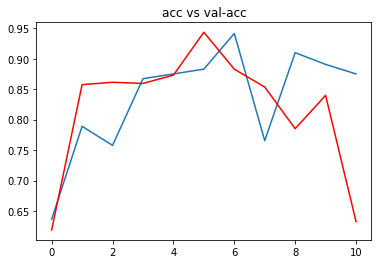

In [ ]:
plt.plot(h['accuracy']) 
plt.plot(h['val_accuracy'], c = 'red') 
plt.title("acc vs val-acc") 
plt.show() 

The MRI image is showing Healthey Brain


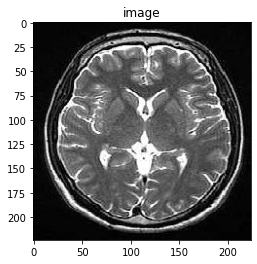

In [ ]:
from keras.preprocessing import image

# path for the image to see if it predics correct class 
path = "/content/BrainTumorData/Brain Tumor Data Set/Healthey/Not Cancer  (2020).jpg"
img = image.load_img(path, target_size=(224,224) ) 

i = image.img_to_array(img)/255
input_arr = np.array([i]) 
input_arr.shape 


pred = model.predict(input_arr)

if pred >= 0.5 :
  pred = 1
else :
  pred = 0

if pred == 0: 
  print("The MRI image is showing BRAIN TUMOR") 
else: 
  print("The MRI image is showing Healthey Brain") 

plt.imshow(input_arr[0])
plt.title("image")
plt.show()